# Benchmarking categorical encoders

## Installation

In [ ]:
# !pip install category_encoders

## Modules Importing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_union
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import Ridge


from category_encoders import OrdinalEncoder, OneHotEncoder
from category_encoders import BackwardDifferenceEncoder, HelmertEncoder, BinaryEncoder
from category_encoders import CountEncoder
from category_encoders import LeaveOneOutEncoder, TargetEncoder, JamesSteinEncoder, MEstimateEncoder, WOEEncoder, CatBoostEncoder
from category_encoders.wrapper import NestedCVWrapper


import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore')

In [2]:
np.random.seed(12345)

## Data Generation


In [4]:
def make_categorical_regression(n_samples=100,
                                n_features=10,
                                n_informative=10,
                                n_categories=10,
                                imbalance=0.0,
                                noise=1.0,
                                n_cont_features=0,
                                cont_weight=0.1,
                                interactions=0.0):
    """Generate a regression problem with categorical features.
  
    Parameters
    ----------
    n_samples : int > 0
        Number of samples to generate
        Default = 100
    n_features : int > 0
        Number of categorical features to generate
        Default = 10
    n_informative : int >= 0
        Number of features which carry information about the target.
        Default = 10
    n_categories : int > 0
        Number of categories per feature.  Default = 10
    imbalance : float > 0
        How much imbalance there is in the number of occurrences of
        each category.  Larger values yield a higher concentration
        of samples in only a few categories.  An imbalance of 0 
        yields the same number of samples in each category.
        Default = 0.0
    noise : float > 0
        Noise to add to target.  Default = 1.0
    n_cont_features : int >= 0
        Number of continuous (non-categorical) features.
        Default = 0
    cont_weight : float > 0
        Weight of the continuous variables' effect.
        Default = 0.1
    interactions : float >= 0 and <= 1
        Proportion of the variance due to interaction effects.
        Note that this only adds interaction effects between the 
        categorical features, not the continuous features.
        Default = 0.0
        
    Returns
    -------
    X : pandas DataFrame
        Features.  Of shape (n_samples, n_features+n_cont_features)
    y : pandas Series of shape (n_samples,)
        Target variable.
    """
    
    
    def beta_binomial(n, a, b):
        """Beta-binomial probability mass function.
        
        Parameters
        ----------
        n : int
            Number of trials
        a : float > 0
            Alpha parameter
        b : float > 0
            Beta parameter
            
        Returns
        -------
        ndarray of size (n,)
            Probability mass function.
        """
        from scipy.special import beta
        from scipy.special import comb
        k = np.arange(n+1)
        return comb(n, k)*beta(k+a, n-k+b)/beta(a, b)


    # Check inputs
    if not isinstance(n_samples, int):
        raise TypeError('n_samples must be an int')
    if n_samples < 1:
        raise ValueError('n_samples must be one or greater')
    if not isinstance(n_features, int):
        raise TypeError('n_features must be an int')
    if n_features < 1:
        raise ValueError('n_features must be one or greater')
    if not isinstance(n_informative, int):
        raise TypeError('n_informative must be an int')
    if n_informative < 0:
        raise ValueError('n_informative must be non-negative')
    if not isinstance(n_categories, int):
        raise TypeError('n_categories must be an int')
    if n_categories < 1:
        raise ValueError('n_categories must be one or greater')
    if not isinstance(imbalance, float):
        raise TypeError('imbalance must be a float')
    if imbalance < 0:
        raise ValueError('imbalance must be non-negative')
    if not isinstance(noise, float):
        raise TypeError('noise must be a float')
    if noise < 0:
        raise ValueError('noise must be positive')
    if not isinstance(n_cont_features, int):
        raise TypeError('n_cont_features must be an int')
    if n_cont_features < 0:
        raise ValueError('n_cont_features must be non-negative')
    if not isinstance(cont_weight, float):
        raise TypeError('cont_weight must be a float')
    if cont_weight < 0:
        raise ValueError('cont_weight must be non-negative')
    if not isinstance(interactions, float):
        raise TypeError('interactions must be a float')
    if interactions < 0:
        raise ValueError('interactions must be non-negative')
        
    # Generate random categorical data (using category probabilities
    # drawn from a beta-binomial dist w/ alpha=1, beta=imbalance+1)
    cat_probs = beta_binomial(n_categories-1, 1.0, imbalance+1)
    categories = np.empty((n_samples, n_features), dtype='uint64')
    for iC in range(n_features):
        categories[:,iC] = np.random.choice(np.arange(n_categories),
                                            size=n_samples,
                                            p=cat_probs)
        
    # Generate random values for each category
    cat_vals = np.random.randn(n_categories, n_features)
    
    # Set non-informative columns' effect to 0
    cat_vals[:,:(n_features-n_informative)] = 0
    
    # Compute target variable from those categories and their values
    y = np.zeros(n_samples)
    for iC in range(n_features):
        y += (1.0-interactions) * cat_vals[categories[:,iC], iC]
      
    # Add interaction effects
    if interactions > 0:
        for iC1 in range(n_informative):
            for iC2 in range(iC1+1, n_informative):
                int_vals = np.random.randn(n_categories, #interaction
                                           n_categories) #effects
                y += interactions * int_vals[categories[:,iC1],
                                             categories[:,iC2]]
    
    # Add noise
    y += noise*np.random.randn(n_samples)
    
    # Generate dataframe from categories
    cat_strs = [''.join([chr(ord(c)+49) for c in str(n)]) 
                for n in range(n_categories)]
    X = pd.DataFrame()
    for iC in range(n_features):
        col_str = 'categorical_'+str(iC)
        X[col_str] = [cat_strs[i] for i in categories[:,iC]]
        
    # Add continuous features
    for iC in range(n_cont_features):
        col_str = 'continuous_'+str(iC)
        X[col_str] = cont_weight*np.random.randn(n_samples)
        y += np.random.randn()*X[col_str]
                    
    # Generate series from target
    y = pd.Series(data=y, index=X.index)
    
    for col in X:

        add_miss_rat = 0.08
        vals_to_nan = X[col].dropna().sample(frac=add_miss_rat).index
        X.loc[vals_to_nan, col] = np.NaN
    
    # Return features and target
    return X, y

Создадим задачу регрессии с 10 категориальными признаками, количество образцов равно 2000, в каждом признаке не более 10 значений + пропуски. 

In [5]:
# Generate categorical data and target
X, y = make_categorical_regression(n_samples=2000,
                                   n_features=10,
                                   n_categories=10,
                                   n_informative=1,
                                   imbalance=2.0)

# Split into test and training data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5)

In [6]:
X_train.head(10)

,categorical_0,categorical_1,categorical_2,categorical_3,categorical_4,categorical_5,categorical_6,categorical_7,categorical_8,categorical_9
878,d,a,b,f,c,e,a,b,f,d
988,f,e,a,a,f,a,a,a,c,e
305,g,g,c,d,b,c,a,c,c,b
1644,e,a,b,b,a,a,d,g,NaN,d
489,e,b,a,a,d,a,b,c,a,c
1900,a,NaN,e,NaN,a,NaN,a,e,d,c
213,d,b,NaN,d,NaN,b,a,b,c,c
474,b,b,a,d,c,NaN,c,d,a,e
347,b,b,b,b,d,f,d,c,e,c
1496,e,a,a,b,b,b,a,d,NaN,NaN


In [7]:
len(X_train['categorical_1'].unique())

11

In [8]:
for column in X_train.columns:
    print(f'number of values in {column} = {len(X_train[column].unique())}')

number of values in categorical_0 = 10
number of values in categorical_1 = 11
number of values in categorical_2 = 11
number of values in categorical_3 = 11
number of values in categorical_4 = 11
number of values in categorical_5 = 11
number of values in categorical_6 = 11
number of values in categorical_7 = 11
number of values in categorical_8 = 11
number of values in categorical_9 = 11


In [9]:
y_train

878     1.419698
988    -1.192324
305    -0.231321
1644    2.574482
489     2.415126
          ...   
1397    2.630310
1789    2.401440
373     1.851736
614     0.589433
181     2.258698
Length: 1000, dtype: float64

<AxesSubplot:>

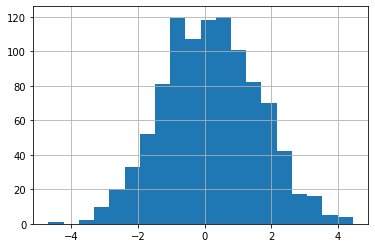

In [10]:
y_train.hist(bins=20)

## Baseline (МАЕ)

Для оценки будет использовать среднее абсолютное значение

In [11]:
errors = {'method': [],'train':[], 'test':[], 'shape': []}

In [12]:
errors['method'] += ['Raw MAE']
errors['shape'] += [X_train.shape[1]]

In [13]:
print(mean_absolute_error(y_train, 
                    np.full(y_train.shape[0], y_train.mean())))

errors['train'] += [mean_absolute_error(y_train, 
                    np.full(y_train.shape[0], y_train.mean()))]

1.1527288324743703


In [14]:
print(mean_absolute_error(y_test, 
                    np.full(y_test.shape[0], y_train.mean())))

errors['test'] += [mean_absolute_error(y_test, 
                    np.full(y_test.shape[0], y_train.mean()))]

1.152976907674121


In [15]:
pd.DataFrame(errors)

,method,train,test,shape
0,Raw MAE,1.152729,1.152977,10


## Ordinal Encoder

In [16]:
# Label encode the categorical data
errors['method'] += ['Ordinary Encoder']
le = OrdinalEncoder()
X_label_encoded = le.fit_transform(X_train, y_train)
errors['shape'] += [X_label_encoded.shape[1]]
X_label_encoded.head(10)

,categorical_0,categorical_1,categorical_2,categorical_3,categorical_4,categorical_5,categorical_6,categorical_7,categorical_8,categorical_9
878,1,1,1,1,1,1,1,1,1,1
988,2,2,2,2,2,2,1,2,2,2
305,3,3,3,3,3,3,1,3,2,3
1644,4,1,1,4,4,2,2,4,11,1
489,4,4,2,2,5,2,3,3,3,4
1900,5,11,4,11,4,11,1,5,4,4
213,1,4,11,3,11,4,1,1,2,4
474,6,4,2,3,1,11,4,6,3,2
347,6,4,1,4,5,5,2,3,5,4
1496,4,1,2,4,3,4,1,6,11,11


In [17]:
X_label_encoded['categorical_0'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8, 10,  9])

In [18]:
# Regression model
model_le = Pipeline([
    ('label-encoder', OrdinalEncoder()),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler()),
    ('regressor', Ridge())
])

# Cross-validated MAE
mae_scorer = make_scorer(mean_absolute_error)
scores = cross_val_score(model_le, X_train, y_train, 
                         cv=3, scoring=mae_scorer)
print('Cross-validated MAE: %0.3f +/- %0.3f'
      % (scores.mean(), scores.std()))

errors['train'] += [scores.mean()]

Cross-validated MAE: 1.154 +/- 0.026


In [19]:
# MAE on test data
model_le.fit(X_train, y_train)
y_pred = model_le.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
print('Validation MAE: %0.3f' % test_mae)
errors['test'] += [test_mae]

Validation MAE: 1.142


In [20]:
pd.DataFrame(errors)

,method,train,test,shape
0,Raw MAE,1.152729,1.152977,10
1,Ordinary Encoder,1.153679,1.141711,10


## Count Encoding

In [21]:
errors['method'] += ['Count Encoding']
coue = CountEncoder()
X_coue = coue.fit_transform(X_train, y_train)
errors['shape'] += [X_coue.shape[1]]
X_coue.head()

,categorical_0,categorical_1,categorical_2,categorical_3,categorical_4,categorical_5,categorical_6,categorical_7,categorical_8,categorical_9
878,138,218,185,63,153,91,212,164,56,120
988,66,90,231,236,75,233,212,222,153,73
305,37,37,149,115,182,144,212,152,153,183
1644,84,218,185,192,206,233,111,51,81,120
489,84,182,231,236,106,233,215,152,249,153


In [22]:
# Regression model
model_oh = Pipeline([
    ('encoder', CountEncoder(min_group_size=1)),
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='mean')),
    ('regressor', Ridge())
])

# Cross-validated MAE
scores = cross_val_score(model_oh, X_train, y_train, 
                         cv=3, scoring=mae_scorer)
print('Cross-validated MAE:', scores.mean(), '+/-', scores.std())
errors['train'] += [scores.mean()]

Cross-validated MAE: 1.1671290011667852 +/- 0.03569368091266391


In [23]:
# MAE on test data
model_oh.fit(X_train, y_train)
y_pred = model_oh.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
print('Validation MAE:', test_mae)
errors['test'] += [test_mae]

Validation MAE: 1.1463631139228705


In [24]:
pd.DataFrame(errors)


,method,train,test,shape
0,Raw MAE,1.152729,1.152977,10
1,Ordinary Encoder,1.153679,1.141711,10
2,Count Encoding,1.167129,1.146363,10


## One-Hot Encoding

In [25]:
# One-hot-encode the categorical data
errors['method'] += ['One-Hot Encoding']
ohe = OneHotEncoder()
X_one_hot = ohe.fit_transform(X_train, y_train)
errors['shape'] += [X_one_hot.shape[1]]
X_one_hot.head()

,categorical_0_1,categorical_0_2,categorical_0_3,categorical_0_4,categorical_0_5,categorical_0_6,categorical_0_7,categorical_0_8,categorical_0_9,categorical_0_10,...,categorical_9_2,categorical_9_3,categorical_9_4,categorical_9_5,categorical_9_6,categorical_9_7,categorical_9_8,categorical_9_9,categorical_9_10,categorical_9_11
878,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
988,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
305,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1644,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
489,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [26]:
# Compare sizes
print('Original size:', X_train.shape)
print('One-hot encoded size:', X_one_hot.shape)

Original size: (1000, 10)
One-hot encoded size: (1000, 109)


In [27]:
# Regression model
model_oh = Pipeline([
    ('encoder', OneHotEncoder(handle_missing='return_nan')),
#     ('encoder', OneHotEncoder()),    
    
    ('imputer', SimpleImputer(strategy='most_frequent')),
    
    ('scaler', StandardScaler()),
    ('regressor', Ridge())
])

# Cross-validated MAE
scores = cross_val_score(model_oh, X_train, y_train, 
                         cv=3, scoring=mae_scorer)
print('Cross-validated MAE:', scores.mean(), '+/-', scores.std())
errors['train'] += [scores.mean()]

Cross-validated MAE: 0.8966054184944182 +/- 0.0065453901209490805


In [28]:
# MAE on test data
model_oh.fit(X_train, y_train)
y_pred = model_oh.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
print('Validation MAE:', test_mae)
errors['test'] += [test_mae]

Validation MAE: 0.8669740336288889


In [29]:
pd.DataFrame(errors)

,method,train,test,shape
0,Raw MAE,1.152729,1.152977,10
1,Ordinary Encoder,1.153679,1.141711,10
2,Count Encoding,1.167129,1.146363,10
3,One-Hot Encoding,0.896605,0.866974,109


## Binary Encoding

In [30]:
bin(11)

'0b1011'

In [ ]:
help(bin)

In [31]:
errors['method'] += ['Binary Encoding']
bd = BinaryEncoder(drop_invariant=True) #удаляет ведущий ноль
X_bd = bd.fit_transform(X_train, y_train)
errors['shape'] += [X_bd.shape[1]]
X_bd.head()

,categorical_0_0,categorical_0_1,categorical_0_2,categorical_0_3,categorical_1_0,categorical_1_1,categorical_1_2,categorical_1_3,categorical_2_0,categorical_2_1,...,categorical_7_2,categorical_7_3,categorical_8_0,categorical_8_1,categorical_8_2,categorical_8_3,categorical_9_0,categorical_9_1,categorical_9_2,categorical_9_3
878,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,1
988,0,0,1,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,1,0
305,0,0,1,1,0,0,1,1,0,0,...,1,1,0,0,1,0,0,0,1,1
1644,0,1,0,0,0,0,0,1,0,0,...,0,0,1,0,1,1,0,0,0,1
489,0,1,0,0,0,1,0,0,0,0,...,1,1,0,0,1,1,0,1,0,0


In [32]:
# Compare sizes
print('Original size:', X_train.shape)
print('Binary encoded size:', X_bd.shape)

Original size: (1000, 10)
Binary encoded size: (1000, 40)


In [33]:
# Regression model
model_oh = Pipeline([
    ('encoder', BinaryEncoder()),
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='mean')),
    ('regressor', Ridge())
])

# Cross-validated MAE
scores = cross_val_score(model_oh, X_train, y_train, 
                         cv=3, scoring=mae_scorer)
print('Cross-validated MAE:', scores.mean(), '+/-', scores.std())
errors['train'] += [scores.mean()]

Cross-validated MAE: 1.0889099879010176 +/- 0.012943863363808272


In [34]:
# MAE on test data
model_oh.fit(X_train, y_train)
y_pred = model_oh.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
print('Validation MAE:', test_mae)
errors['test'] += [test_mae]

Validation MAE: 1.0600207629271954


In [35]:
pd.DataFrame(errors)

,method,train,test,shape
0,Raw MAE,1.152729,1.152977,10
1,Ordinary Encoder,1.153679,1.141711,10
2,Count Encoding,1.167129,1.146363,10
3,One-Hot Encoding,0.896605,0.866974,109
4,Binary Encoding,1.088910,1.060021,40


## Helmert Encoding

In [36]:
errors['method'] += ['Helmert Encoding']
he = HelmertEncoder(drop_invariant=True) #удаляет ведущий ноль
X_he = he.fit_transform(X_train, y_train)
errors['shape'] += [X_he.shape[1]]
X_he.head()

,categorical_0_0,categorical_0_1,categorical_0_2,categorical_0_3,categorical_0_4,categorical_0_5,categorical_0_6,categorical_0_7,categorical_0_8,categorical_1_0,...,categorical_9_0,categorical_9_1,categorical_9_2,categorical_9_3,categorical_9_4,categorical_9_5,categorical_9_6,categorical_9_7,categorical_9_8,categorical_9_9
878,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
988,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,...,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
305,0.0,2.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,...,0.0,2.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1644,0.0,0.0,3.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
489,0.0,0.0,3.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,...,0.0,0.0,3.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [37]:
# Compare sizes
print('Original size:', X_train.shape)
print('Helmert encoded size:', X_he.shape)

Original size: (1000, 10)
Helmert encoded size: (1000, 99)


In [38]:
# Regression model
model_he = Pipeline([
    ('encoder', HelmertEncoder()),
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='mean')),
    ('regressor', Ridge())
])

# Cross-validated MAE
scores = cross_val_score(model_he, X_train, y_train, 
                         cv=3, scoring=mae_scorer)
print('Cross-validated MAE:', scores.mean(), '+/-', scores.std())
errors['train'] += [scores.mean()]

Cross-validated MAE: 0.8971745171317246 +/- 0.006092943627210301


In [39]:
# MAE on test data
model_he.fit(X_train, y_train)
y_pred = model_he.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
print('Validation MAE:', test_mae)
errors['test'] += [test_mae]

Validation MAE: 0.8668806924531702


In [40]:
pd.DataFrame(errors)

,method,train,test,shape
0,Raw MAE,1.152729,1.152977,10
1,Ordinary Encoder,1.153679,1.141711,10
2,Count Encoding,1.167129,1.146363,10
3,One-Hot Encoding,0.896605,0.866974,109
4,Binary Encoding,1.088910,1.060021,40
5,Helmert Encoding,0.897175,0.866881,99


## BackwardDifferenceEncoder

In [41]:
errors['method'] += ['BackwardDifference Encoding']
bd = BackwardDifferenceEncoder(drop_invariant=True) #удаляет ведущий ноль
X_bd = bd.fit_transform(X_train, y_train)
errors['shape'] += [X_bd.shape[1]]
X_bd.head()

,categorical_0_0,categorical_0_1,categorical_0_2,categorical_0_3,categorical_0_4,categorical_0_5,categorical_0_6,categorical_0_7,categorical_0_8,categorical_1_0,...,categorical_9_0,categorical_9_1,categorical_9_2,categorical_9_3,categorical_9_4,categorical_9_5,categorical_9_6,categorical_9_7,categorical_9_8,categorical_9_9
878,-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,-0.909091,...,-0.909091,-0.818182,-0.727273,-0.636364,-0.545455,-0.454545,-0.363636,-0.272727,-0.181818,-0.090909
988,0.1,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0.090909,...,0.090909,-0.818182,-0.727273,-0.636364,-0.545455,-0.454545,-0.363636,-0.272727,-0.181818,-0.090909
305,0.1,0.2,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0.090909,...,0.090909,0.181818,-0.727273,-0.636364,-0.545455,-0.454545,-0.363636,-0.272727,-0.181818,-0.090909
1644,0.1,0.2,0.3,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,-0.909091,...,-0.909091,-0.818182,-0.727273,-0.636364,-0.545455,-0.454545,-0.363636,-0.272727,-0.181818,-0.090909
489,0.1,0.2,0.3,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0.090909,...,0.090909,0.181818,0.272727,-0.636364,-0.545455,-0.454545,-0.363636,-0.272727,-0.181818,-0.090909


In [42]:
# Compare sizes
print('Original size:', X_train.shape)
print('Helmert encoded size:', X_bd.shape)

Original size: (1000, 10)
Helmert encoded size: (1000, 99)


In [43]:
# Regression model
model_bd = Pipeline([
    ('encoder', BackwardDifferenceEncoder()),
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='mean')),
    ('regressor', Ridge())
])

# Cross-validated MAE
scores = cross_val_score(model_bd, X_train, y_train, 
                         cv=3, scoring=mae_scorer)
print('Cross-validated MAE:', scores.mean(), '+/-', scores.std())
errors['train'] += [scores.mean()]

Cross-validated MAE: 0.8963082579210969 +/- 0.00630949368675888


In [44]:
# MAE on test data
model_bd.fit(X_train, y_train)
y_pred = model_bd.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
print('Validation MAE:', test_mae)
errors['test'] += [test_mae]

Validation MAE: 0.8658905636979023


In [45]:
pd.DataFrame(errors)

,method,train,test,shape
0,Raw MAE,1.152729,1.152977,10
1,Ordinary Encoder,1.153679,1.141711,10
2,Count Encoding,1.167129,1.146363,10
3,One-Hot Encoding,0.896605,0.866974,109
4,Binary Encoding,1.088910,1.060021,40
5,Helmert Encoding,0.897175,0.866881,99
6,BackwardDifference Encoding,0.896308,0.865891,99


## Target Encoding

In [46]:
y_train[X_train[X_train['categorical_0'] == 'a'].index].mean() 

0.1389303264955781

In [47]:
errors['method'] += ['Target Encoding']
te = TargetEncoder()
X_target_encoded = te.fit_transform(X_train, y_train)
errors['shape'] += [X_target_encoded.shape[1]]
X_target_encoded.head()

,categorical_0,categorical_1,categorical_2,categorical_3,categorical_4,categorical_5,categorical_6,categorical_7,categorical_8,categorical_9
878,0.048687,0.105149,0.254408,0.335531,0.326531,0.401084,0.165886,0.139940,-0.091535,2.051528
988,0.147641,0.245556,0.129712,0.256120,0.126966,0.180153,0.165886,0.262572,0.293681,-0.685957
305,0.332669,0.144578,0.230513,0.249642,0.302961,0.239725,0.165886,0.310264,0.293681,-1.193131
1644,0.456792,0.105149,0.254408,0.223898,0.183028,0.180153,0.116573,0.210924,0.330240,2.051528
489,0.456792,0.170270,0.129712,0.256120,0.155722,0.180153,0.256183,0.310264,0.208062,0.723355


In [48]:
# Regression model
model_te = Pipeline([
    ('encoder', TargetEncoder()),
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='mean')),
    ('regressor', Ridge())
])

# Cross-validated MAE
scores = cross_val_score(model_te, X_train, y_train, 
                         cv=3, scoring=mae_scorer)
print('Cross-validated MAE:', scores.mean(), '+/-', scores.std())
errors['train'] += [scores.mean()]

Cross-validated MAE: 0.8812897665300262 +/- 0.01003895493141844


In [49]:
# MAE on test data
model_te.fit(X_train, y_train)
y_pred = model_te.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
print('Validation MAE:', test_mae)
errors['test'] += [test_mae]

Validation MAE: 0.8458976011521858


In [50]:
pd.DataFrame(errors)

,method,train,test,shape
0,Raw MAE,1.152729,1.152977,10
1,Ordinary Encoder,1.153679,1.141711,10
2,Count Encoding,1.167129,1.146363,10
3,One-Hot Encoding,0.896605,0.866974,109
4,Binary Encoding,1.088910,1.060021,40
5,Helmert Encoding,0.897175,0.866881,99
6,BackwardDifference Encoding,0.896308,0.865891,99
7,Target Encoding,0.881290,0.845898,10


## Leave One Out Encoding


In [51]:
errors['method'] += ['Leave One Out Encoding']
te = LeaveOneOutEncoder()
X_target_encoded_loo = te.fit_transform(X_train, y_train)
errors['shape'] += [X_target_encoded_loo.shape[1]]
X_target_encoded_loo.head()

,categorical_0,categorical_1,categorical_2,categorical_3,categorical_4,categorical_5,categorical_6,categorical_7,categorical_8,categorical_9
878,0.038679,0.099091,0.248075,0.320154,0.319339,0.389948,0.159943,0.132089,-0.126636,2.056923
988,0.167900,0.261770,0.135460,0.262283,0.144564,0.186068,0.172323,0.269155,0.303457,-0.683319
305,0.376534,0.147903,0.233633,0.253866,0.305912,0.243020,0.167768,0.313851,0.297135,-1.198416
1644,0.431739,0.093769,0.241799,0.211591,0.171363,0.169832,0.094221,0.164960,0.302522,2.047219
489,0.433659,0.157867,0.119776,0.246932,0.134199,0.170519,0.246094,0.296325,0.199162,0.712226


In [52]:
y_train[X_train['categorical_0'] =='a'].iloc[1:].mean()

0.13889825154726093

In [53]:
# Regression model
model_te_loo = Pipeline([
    ('encoder', LeaveOneOutEncoder()),
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='mean')),
    ('regressor', Ridge())
])

# Cross-validated MAE
scores = cross_val_score(model_te_loo, X_train, y_train, 
                         cv=3, scoring=mae_scorer)
print('Cross-validated MAE:', scores.mean(), '+/-', scores.std())
errors['train'] += [scores.mean()]

Cross-validated MAE: 0.8559010150873649 +/- 0.006070457777463622


In [54]:
# MAE on test data
model_te_loo.fit(X_train, y_train)
y_pred = model_te_loo.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
print('Validation MAE:', test_mae)
errors['test'] += [test_mae]

Validation MAE: 0.8396774600801863


In [55]:
pd.DataFrame(errors)

,method,train,test,shape
0,Raw MAE,1.152729,1.152977,10
1,Ordinary Encoder,1.153679,1.141711,10
2,Count Encoding,1.167129,1.146363,10
3,One-Hot Encoding,0.896605,0.866974,109
4,Binary Encoding,1.088910,1.060021,40
5,Helmert Encoding,0.897175,0.866881,99
6,BackwardDifference Encoding,0.896308,0.865891,99
7,Target Encoding,0.881290,0.845898,10
8,Leave One Out Encoding,0.855901,0.839677,10


## James Stein Encoding

In [56]:
errors['method'] += ['James Stein Encoding']
js = JamesSteinEncoder()
X_js = js.fit_transform(X_train, y_train)
errors['shape'] += [X_js.shape[1]]
X_js.head()

,categorical_0,categorical_1,categorical_2,categorical_3,categorical_4,categorical_5,categorical_6,categorical_7,categorical_8,categorical_9
878,0.100205,0.137496,0.224146,0.274096,0.273002,0.310541,0.171780,0.156156,0.013263,1.522121
988,0.159963,0.224306,0.150086,0.226516,0.149552,0.181085,0.171780,0.230259,0.246713,-0.425510
305,0.283523,0.154821,0.210858,0.222431,0.252333,0.217095,0.171780,0.262471,0.246713,-0.824641
1644,0.349908,0.137496,0.224146,0.208053,0.182798,0.181085,0.143214,0.199422,0.273983,1.522121
489,0.349908,0.175357,0.150086,0.226516,0.165419,0.181085,0.225439,0.262471,0.197881,0.601578


In [57]:
# Regression model
model_oh = Pipeline([
    ('encoder', JamesSteinEncoder()),
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='mean')),
    ('regressor', Ridge())
])

# Cross-validated MAE
scores = cross_val_score(model_oh, X_train, y_train, 
                         cv=3, scoring=mae_scorer)
print('Cross-validated MAE:', scores.mean(), '+/-', scores.std())
errors['train'] += [scores.mean()]

Cross-validated MAE: 0.8778655076760685 +/- 0.0039036329613203057


In [58]:
# MAE on test data
model_oh.fit(X_train, y_train)
y_pred = model_oh.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
print('Validation MAE:', test_mae)
errors['test'] += [test_mae]

Validation MAE: 0.8565878291516763


In [59]:
pd.DataFrame(errors)

,method,train,test,shape
0,Raw MAE,1.152729,1.152977,10
1,Ordinary Encoder,1.153679,1.141711,10
2,Count Encoding,1.167129,1.146363,10
3,One-Hot Encoding,0.896605,0.866974,109
4,Binary Encoding,1.088910,1.060021,40
5,Helmert Encoding,0.897175,0.866881,99
6,BackwardDifference Encoding,0.896308,0.865891,99
7,Target Encoding,0.881290,0.845898,10
8,Leave One Out Encoding,0.855901,0.839677,10
9,James Stein Encoding,0.877866,0.856588,10


## Mix One Hot + Leave One Out

In [60]:
columns = list(X_train.columns)

In [61]:
columns_te = ['te_' + c for c in columns]

In [62]:
X_train1 = pd.concat([X_train, X_train], axis=1)

In [63]:
X_train1.columns = columns + columns_te

In [64]:
X_test1 = pd.concat([X_test, X_test], axis=1)
X_test1.columns = columns + columns_te

In [65]:
X_train1

,categorical_0,categorical_1,categorical_2,categorical_3,categorical_4,categorical_5,categorical_6,categorical_7,categorical_8,categorical_9,te_categorical_0,te_categorical_1,te_categorical_2,te_categorical_3,te_categorical_4,te_categorical_5,te_categorical_6,te_categorical_7,te_categorical_8,te_categorical_9
878,d,a,b,f,c,e,a,b,f,d,d,a,b,f,c,e,a,b,f,d
988,f,e,a,a,f,a,a,a,c,e,f,e,a,a,f,a,a,a,c,e
305,g,g,c,d,b,c,a,c,c,b,g,g,c,d,b,c,a,c,c,b
1644,e,a,b,b,a,a,d,g,NaN,d,e,a,b,b,a,a,d,g,NaN,d
489,e,b,a,a,d,a,b,c,a,c,e,b,a,a,d,a,b,c,a,c
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1397,a,a,c,d,b,a,NaN,f,a,d,a,a,c,d,b,a,NaN,f,a,d
1789,e,f,a,j,g,d,b,e,d,a,e,f,a,j,g,d,b,e,d,a
373,a,g,a,b,g,d,a,a,a,a,a,g,a,b,g,d,a,a,a,a
614,c,f,d,g,e,NaN,f,c,b,c,c,f,d,g,e,NaN,f,c,b,c


In [66]:
preprocessor = ColumnTransformer(
transformers=[
    ('encoder_ohe', OneHotEncoder(), columns),
    ('encoder_te', LeaveOneOutEncoder(), columns_te)
])

In [67]:
# Regression model
model_mix = Pipeline([
    ('preproc', preprocessor),
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='mean')),
    ('regressor', Ridge())
])

# Cross-validated MAE
scores = cross_val_score(model_mix, X_train1, y_train,
                         cv=3, scoring=mae_scorer)
print('Cross-validated MAE:', scores.mean(), '+/-', scores.std())
errors['train'] += [scores.mean()]

Cross-validated MAE: 1.0418752720456654 +/- 0.03450384172807419


In [68]:
errors['method'] += ['Mix One Hot + Leave One Out']

X_train_mix = preprocessor.fit_transform(X_train1, y_train)

errors['shape'] += [X_train_mix.shape[1]]


In [69]:
# MAE on test data
model_mix.fit(X_train1, y_train)
y_pred = model_mix.predict(X_test1)
test_mae = mean_absolute_error(y_test, y_pred)
print('Validation MAE:', test_mae)
errors['test'] += [test_mae]

Validation MAE: 1.0888778348174664


In [70]:
pd.DataFrame(errors)

,method,train,test,shape
0,Raw MAE,1.152729,1.152977,10
1,Ordinary Encoder,1.153679,1.141711,10
2,Count Encoding,1.167129,1.146363,10
3,One-Hot Encoding,0.896605,0.866974,109
4,Binary Encoding,1.088910,1.060021,40
5,Helmert Encoding,0.897175,0.866881,99
6,BackwardDifference Encoding,0.896308,0.865891,99
7,Target Encoding,0.881290,0.845898,10
8,Leave One Out Encoding,0.855901,0.839677,10
9,James Stein Encoding,0.877866,0.856588,10


## Finalizing results

In [71]:
pd.DataFrame(errors).sort_values(by='test')

,method,train,test,shape
8,Leave One Out Encoding,0.855901,0.839677,10
7,Target Encoding,0.881290,0.845898,10
9,James Stein Encoding,0.877866,0.856588,10
6,BackwardDifference Encoding,0.896308,0.865891,99
5,Helmert Encoding,0.897175,0.866881,99
3,One-Hot Encoding,0.896605,0.866974,109
4,Binary Encoding,1.088910,1.060021,40
10,Mix One Hot + Leave One Out,1.041875,1.088878,119
1,Ordinary Encoder,1.153679,1.141711,10
2,Count Encoding,1.167129,1.146363,10


## Минута рефлексии


*   Какие выводы можно сделать по полученным результатам?
*   С какими методами вы познакомились впервые?



# Еще Encoders

- CatBoost Encoding
- Encoding для временных рядов